In [1]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [3]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, 'channel_40x40x20_21tsteps_2923_satifying_cases.h5')
sat_t, logk = load_data(data_path, ['sat', 'logk'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('sw_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)

sw_t shape is  (2923, 20, 40, 40, 21)
logk shape is  (2923, 20, 40, 40, 1)


In [4]:
sat_t[sat_t < 0.1] = 0.1
sat_t[sat_t > 0.8] = 0.8

In [5]:
depth = 10
nr = logk.shape[0]
train_nr = 2500
test_nr = 2923 - train_nr

In [6]:
step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
train_x = np.concatenate([logk[:train_nr, ...], sat_t[:train_nr,:, :, :, [0]]], axis = -1)
train_y = sat_t[:train_nr, :, :, :, step_index]

test_x = np.concatenate([logk[nr-test_nr:, ...],  sat_t[nr-test_nr:, :, :, :, [0]]], axis = -1)
test_y = sat_t[nr-test_nr:,:, :, :, step_index]


# train_x = train_x.transpose(0,2,3,1)
train_y = train_y.transpose(0, 4, 1, 2, 3)
train_y = train_y[:, :, :, :, :, None]
# test_x = test_x.transpose(0,2,3,1)
test_y = test_y.transpose(0, 4, 1, 2, 3)
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2500, 20, 40, 40, 2)
train_y shape is  (2500, 10, 20, 40, 40, 1)
test_x shape is  (423, 20, 40, 40, 2)
test_y shape is  (423, 10, 20, 40, 40, 1)


In [7]:
input_shape=(20, 40, 40, 2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
#vae_model.summary(line_length=150)

In [8]:
output_dir = 'saved_models/'
vae_model.load_weights(output_dir + 'saved-model-10-steps-bs4-lr3e-4-saturation-hd-500-filter_16_32_32_64-mse-340-1053.08.h5')

In [9]:
pred_list = []
test_batch_size = 10 
batch_num = int(test_nr / test_batch_size) + 1
for i in range(batch_num):
    next_batch_idx = min((i+1)*test_batch_size, test_x.shape[0])
    pred_list.append(vae_model.predict(test_x[i*test_batch_size: next_batch_idx, ...]))

pred = np.concatenate(pred_list, axis = 0)
print(pred.shape)

(423, 10, 20, 40, 40, 1)


In [10]:
sat_pred = pred[:, :, :, :, :, 0].transpose(0, 2, 3, 4, 1)
sat_true = test_y[:, :, :, :, :, 0].transpose(0, 2, 3, 4, 1)
print('sat_pred shape is ', sat_pred.shape)
print('sat_true shape is ', sat_true.shape)

sat_pred shape is  (423, 20, 40, 40, 10)
sat_true shape is  (423, 20, 40, 40, 10)


In [11]:
sat_pred[sat_pred < 0.1] = 0.1
sat_pred[sat_pred > 1.0] = 1.0

In [12]:
sat_pred.shape

(423, 20, 40, 40, 10)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

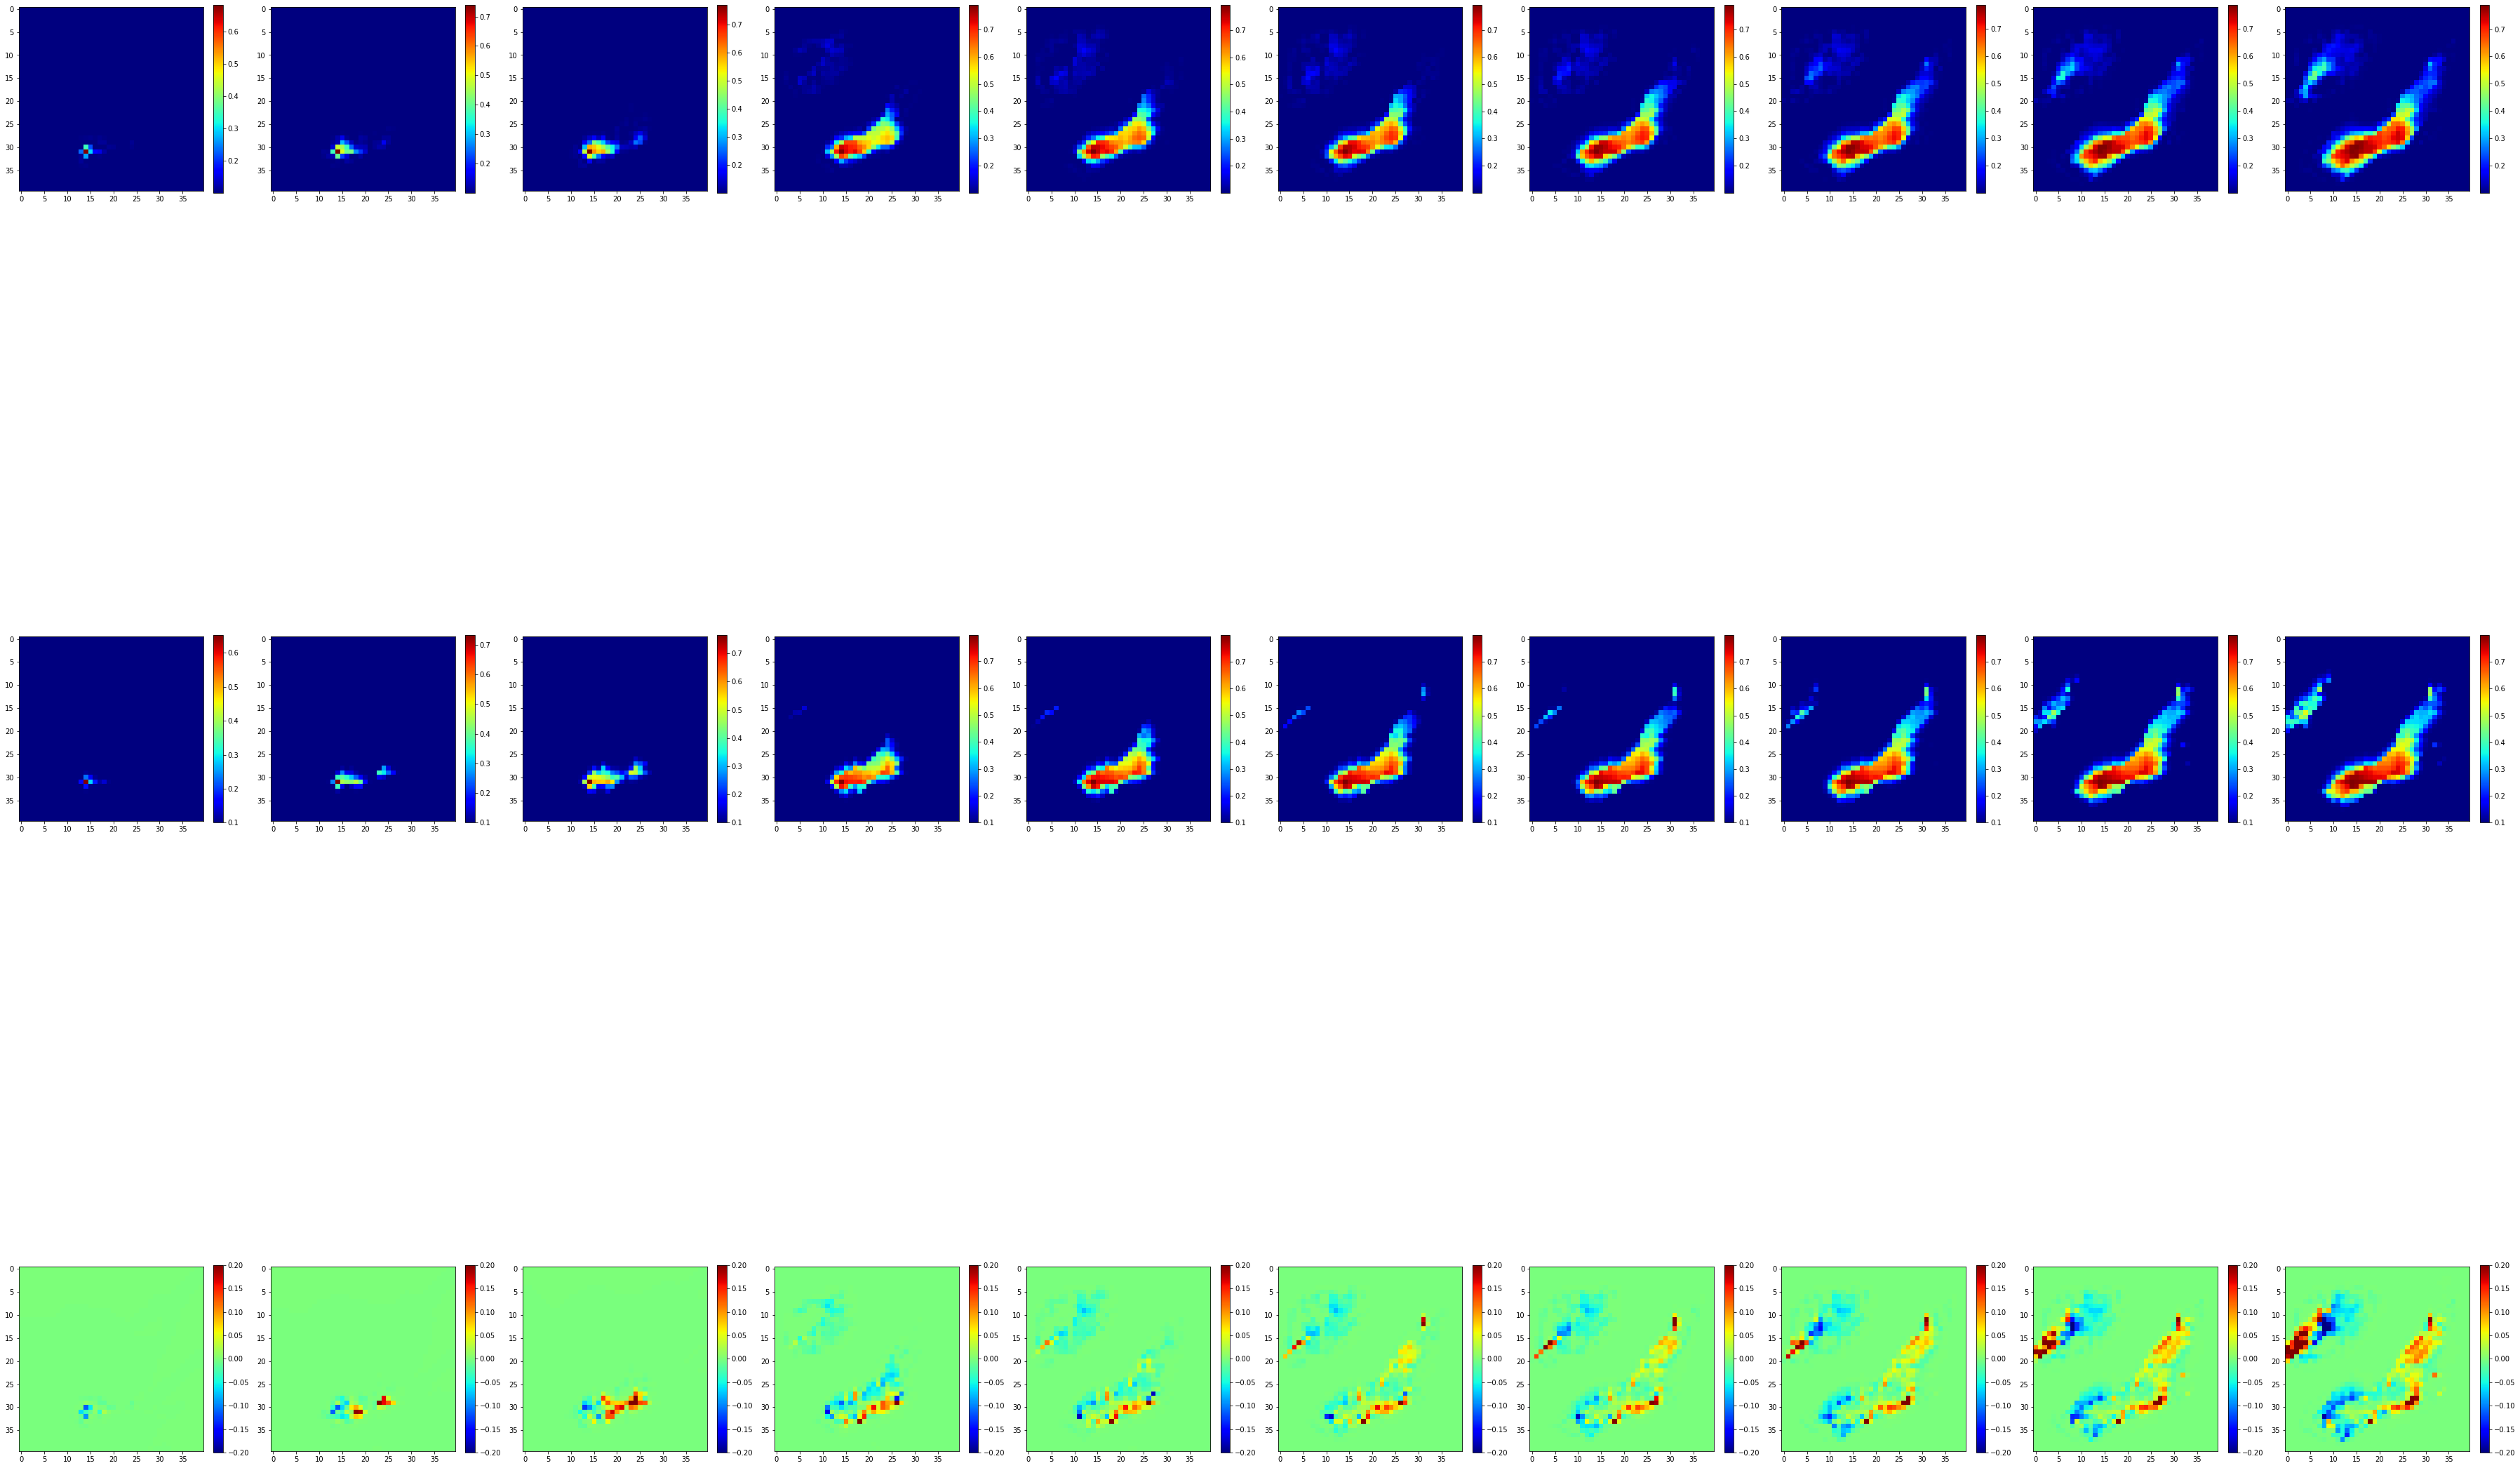

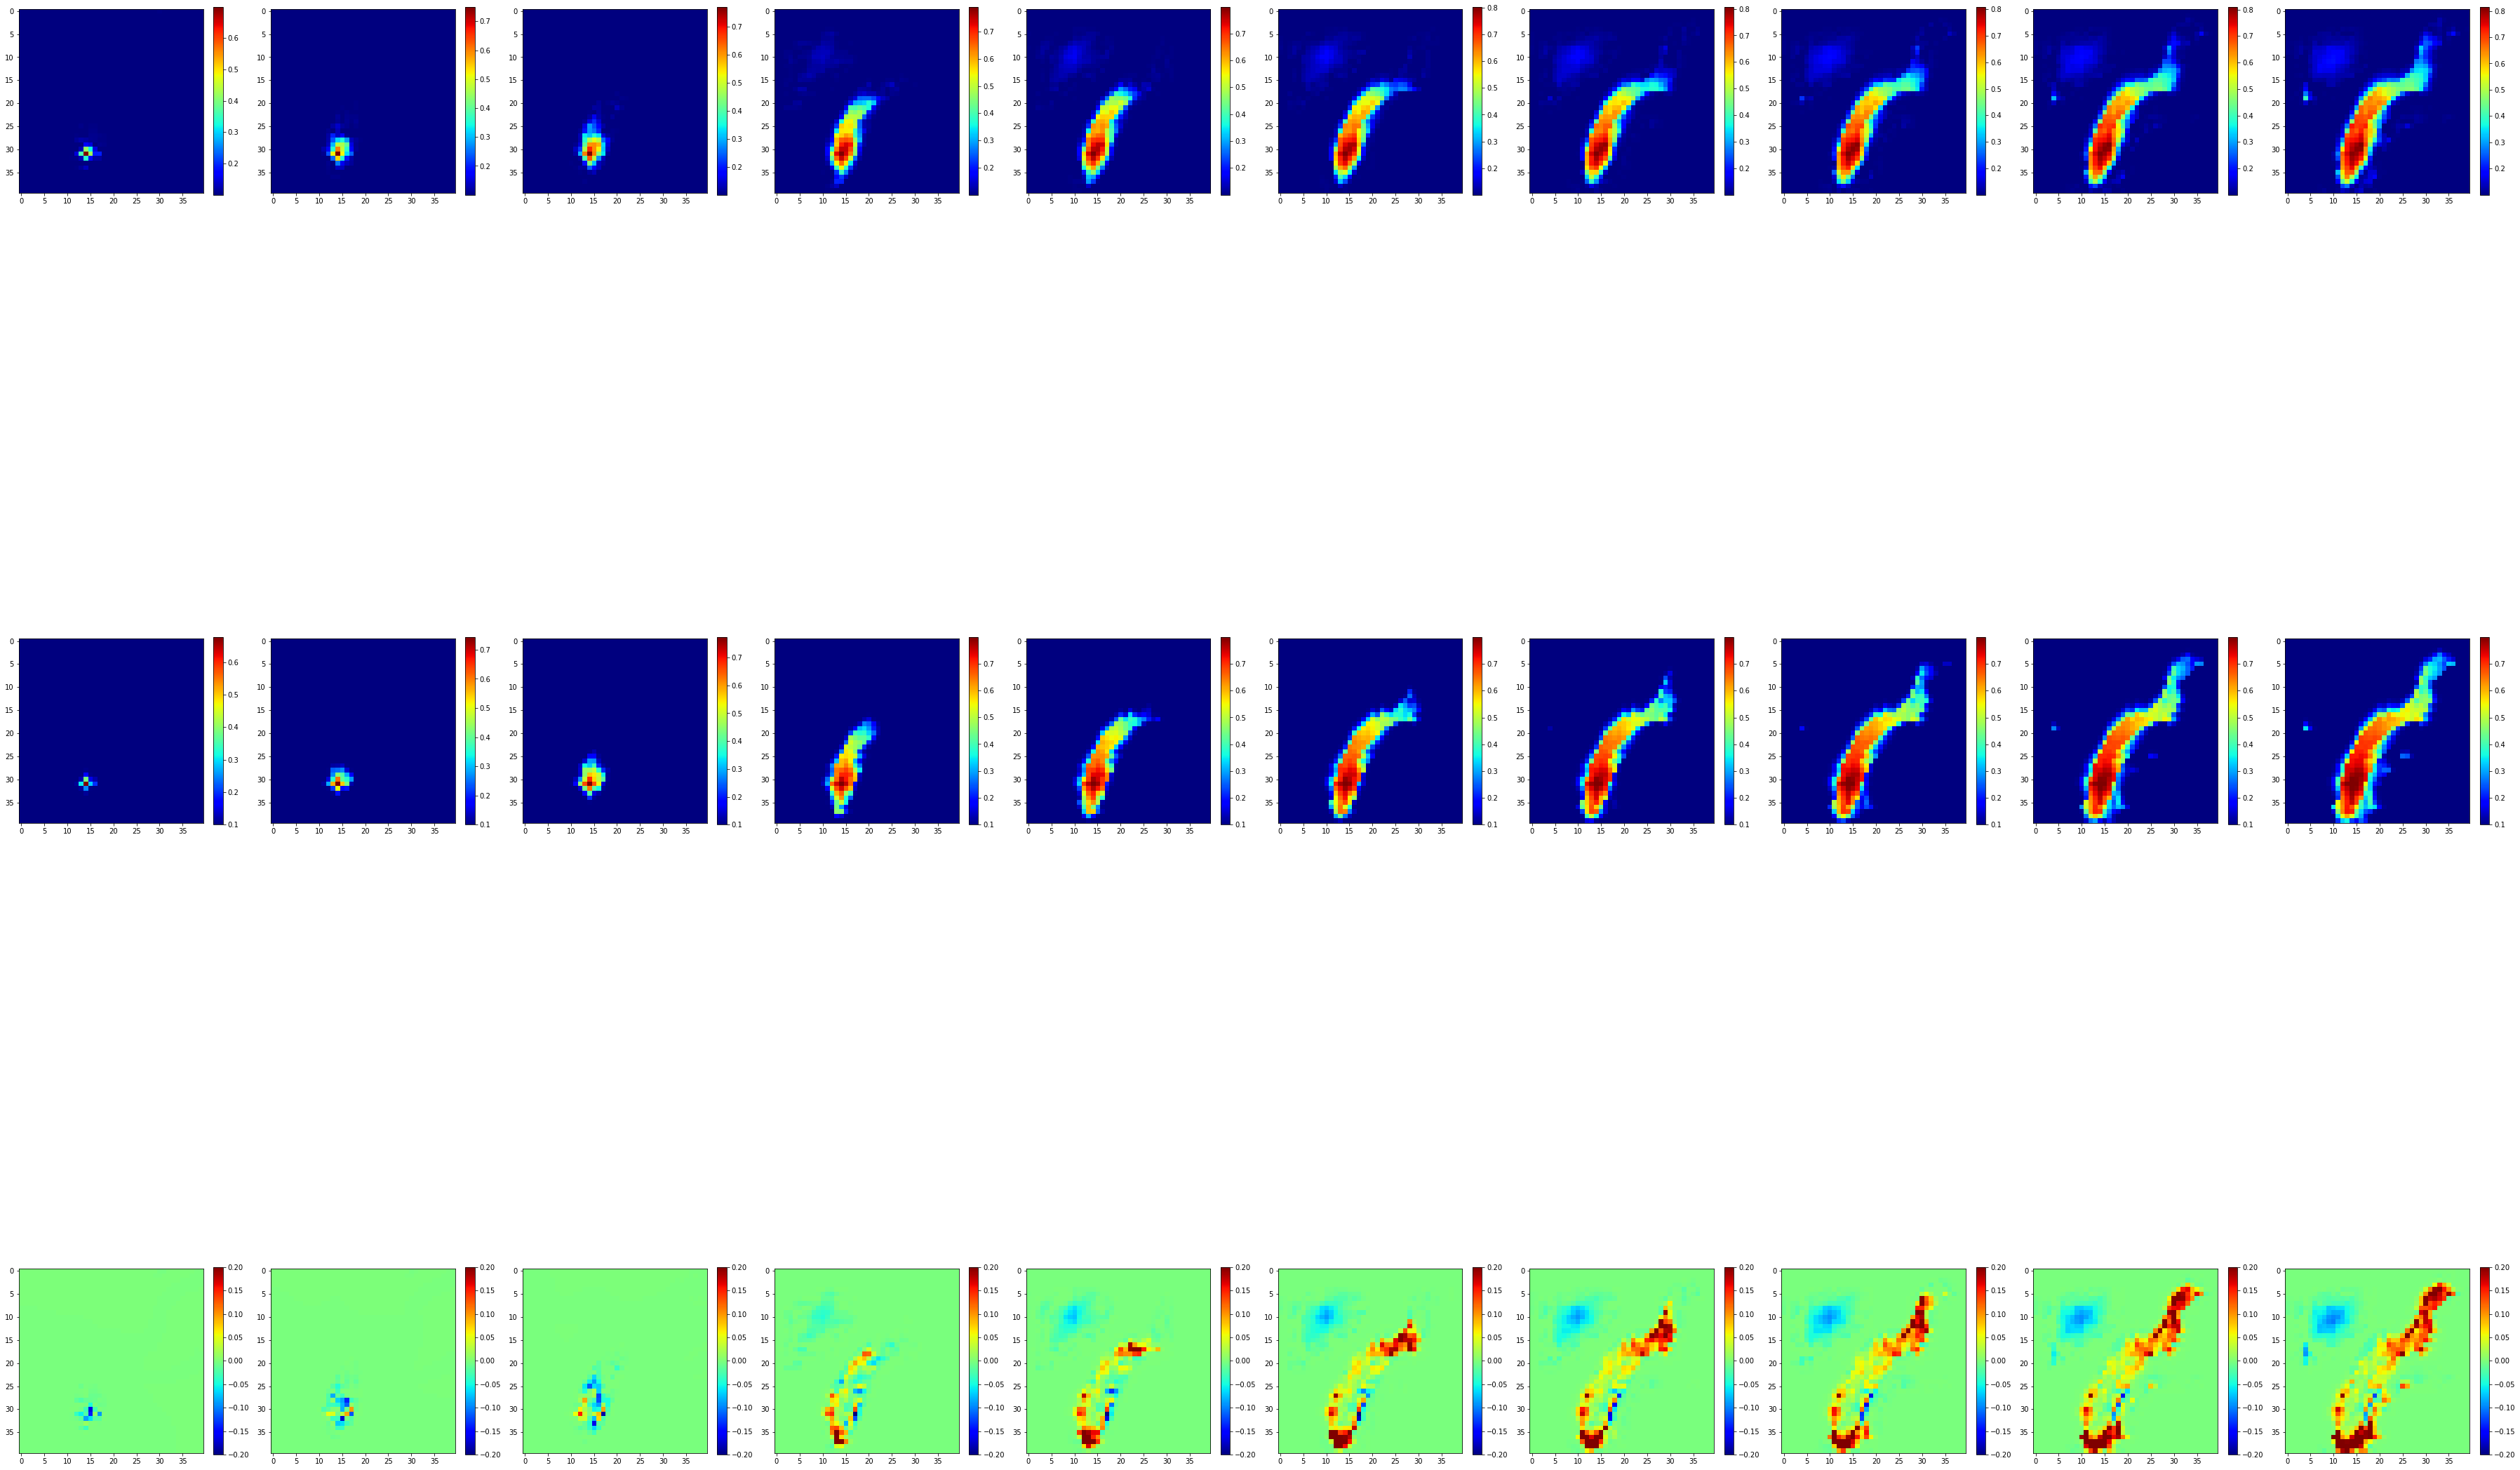

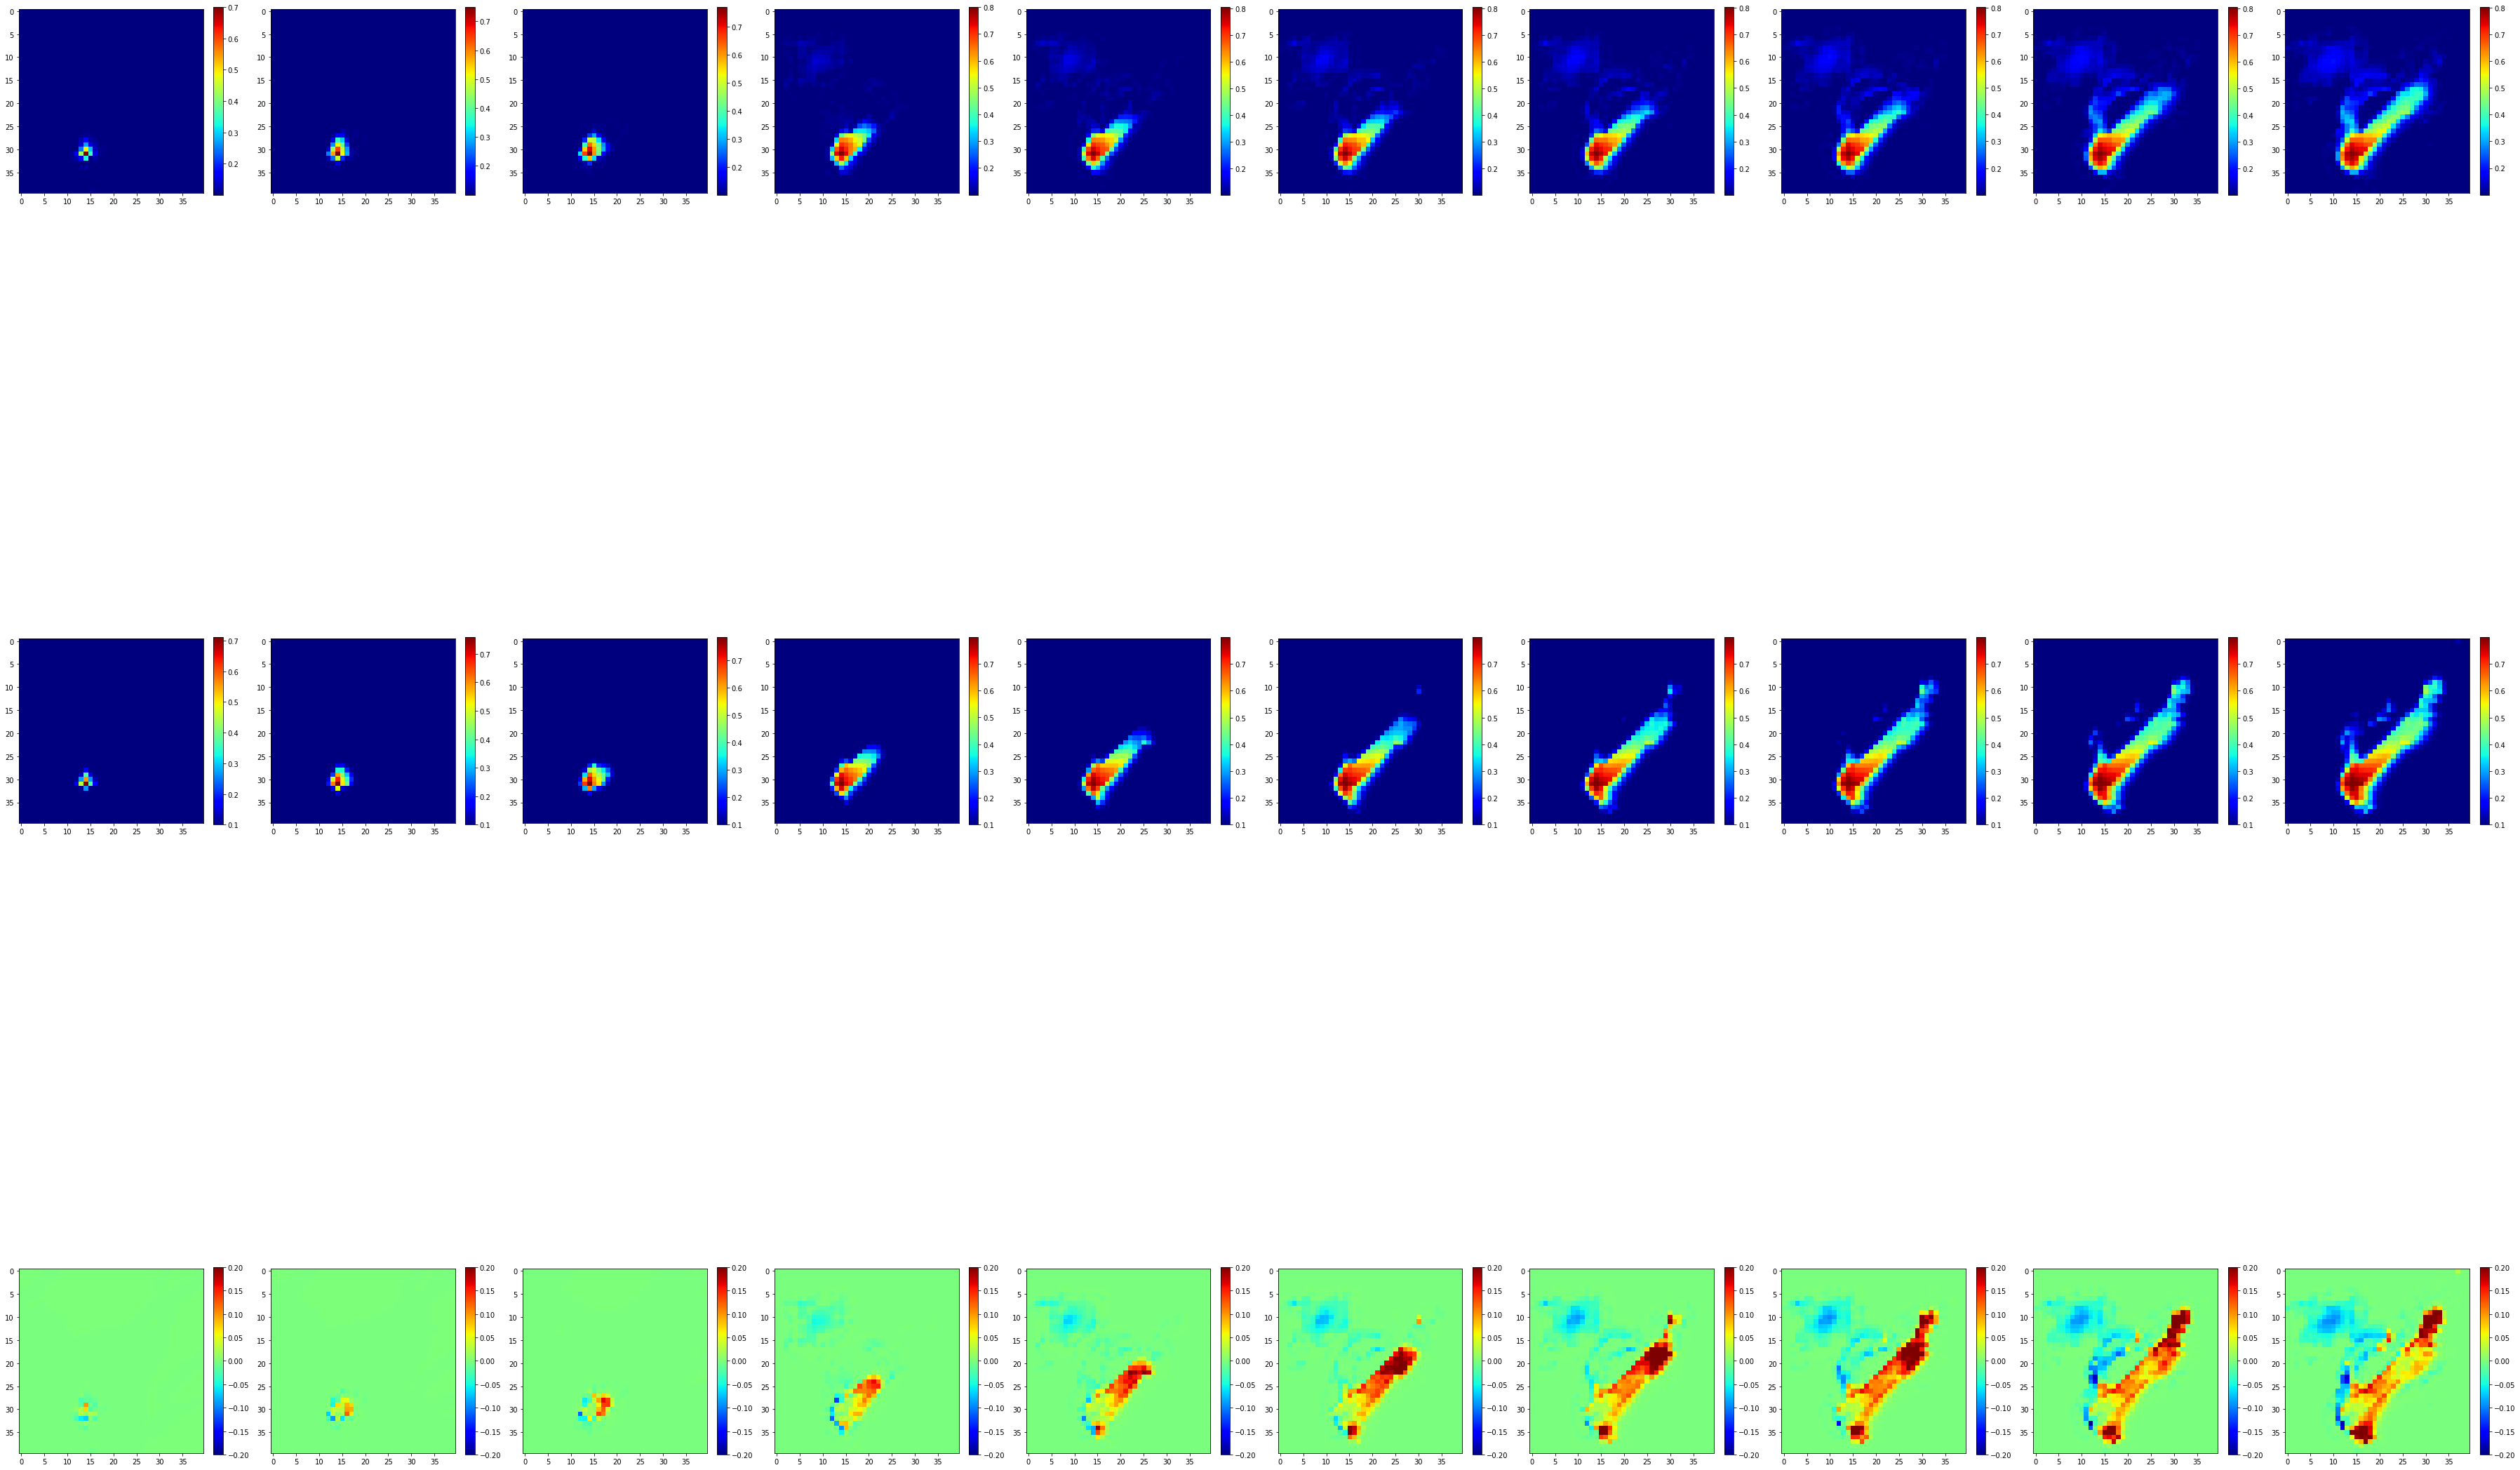

In [14]:
ind_case = [0, 10, 20]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, 0, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, 0, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, 0, :, :, i_tstep] - sat_pred[k, 0, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

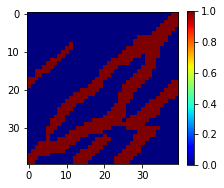

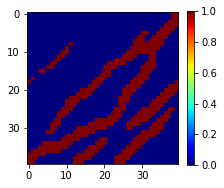

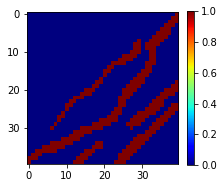

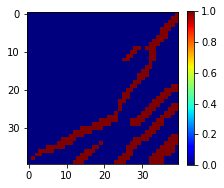

In [15]:
ind_case = [0]
ind_zs = [0, 3, 5, 6]
for k in ind_case:
    
    for z in ind_zs:
        plt.figure(figsize=(3,3))
       
        plt.imshow(test_x[k, z, :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.savefig('case1-k-z={}.png'.format(z + 1))
        plt.show()

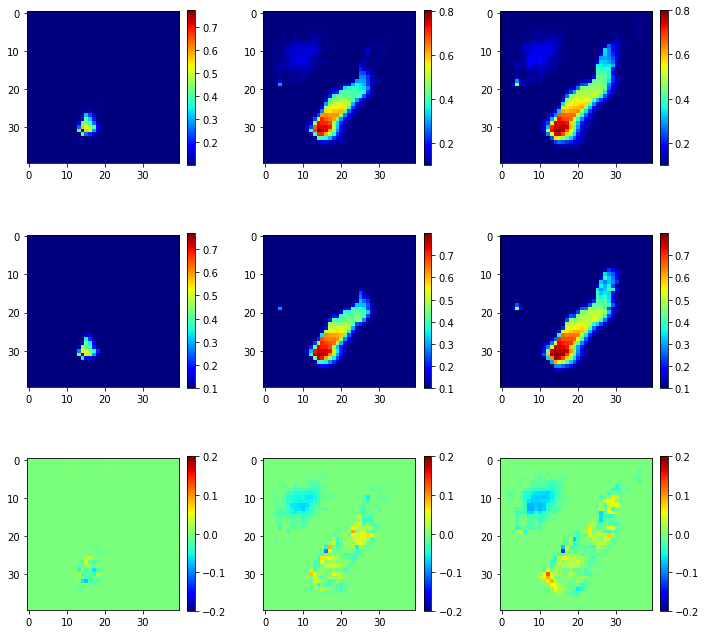

In [16]:
ind_case = [299]
ind_z = 0
time_steps = [2, 5, 7]
for k in ind_case:
    plt.figure(figsize=(10,10))
    for i_tstep in range(len(time_steps)):
        plt.subplot(3, len(time_steps), i_tstep+1)
       
        plt.imshow(sat_pred[k, 0, :, :, time_steps[i_tstep]])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, len(time_steps), i_tstep+1+len(time_steps))
        plt.imshow(sat_true[k, 0, :, :, time_steps[i_tstep]])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, len(time_steps), i_tstep+1+2*len(time_steps))
        plt.imshow(sat_true[k, 0, :, :, time_steps[i_tstep]] - sat_pred[k, 0, :, :, time_steps[i_tstep]])

        cbar = plt.colorbar(fraction=0.046)
        #cbar.ax.tick_params(labelsize=20) 

        plt.clim([-0.2, 0.2])
        plt.tight_layout()
#plt.savefig('case1-z={}.png'.format(ind_z + 1))
plt.show()


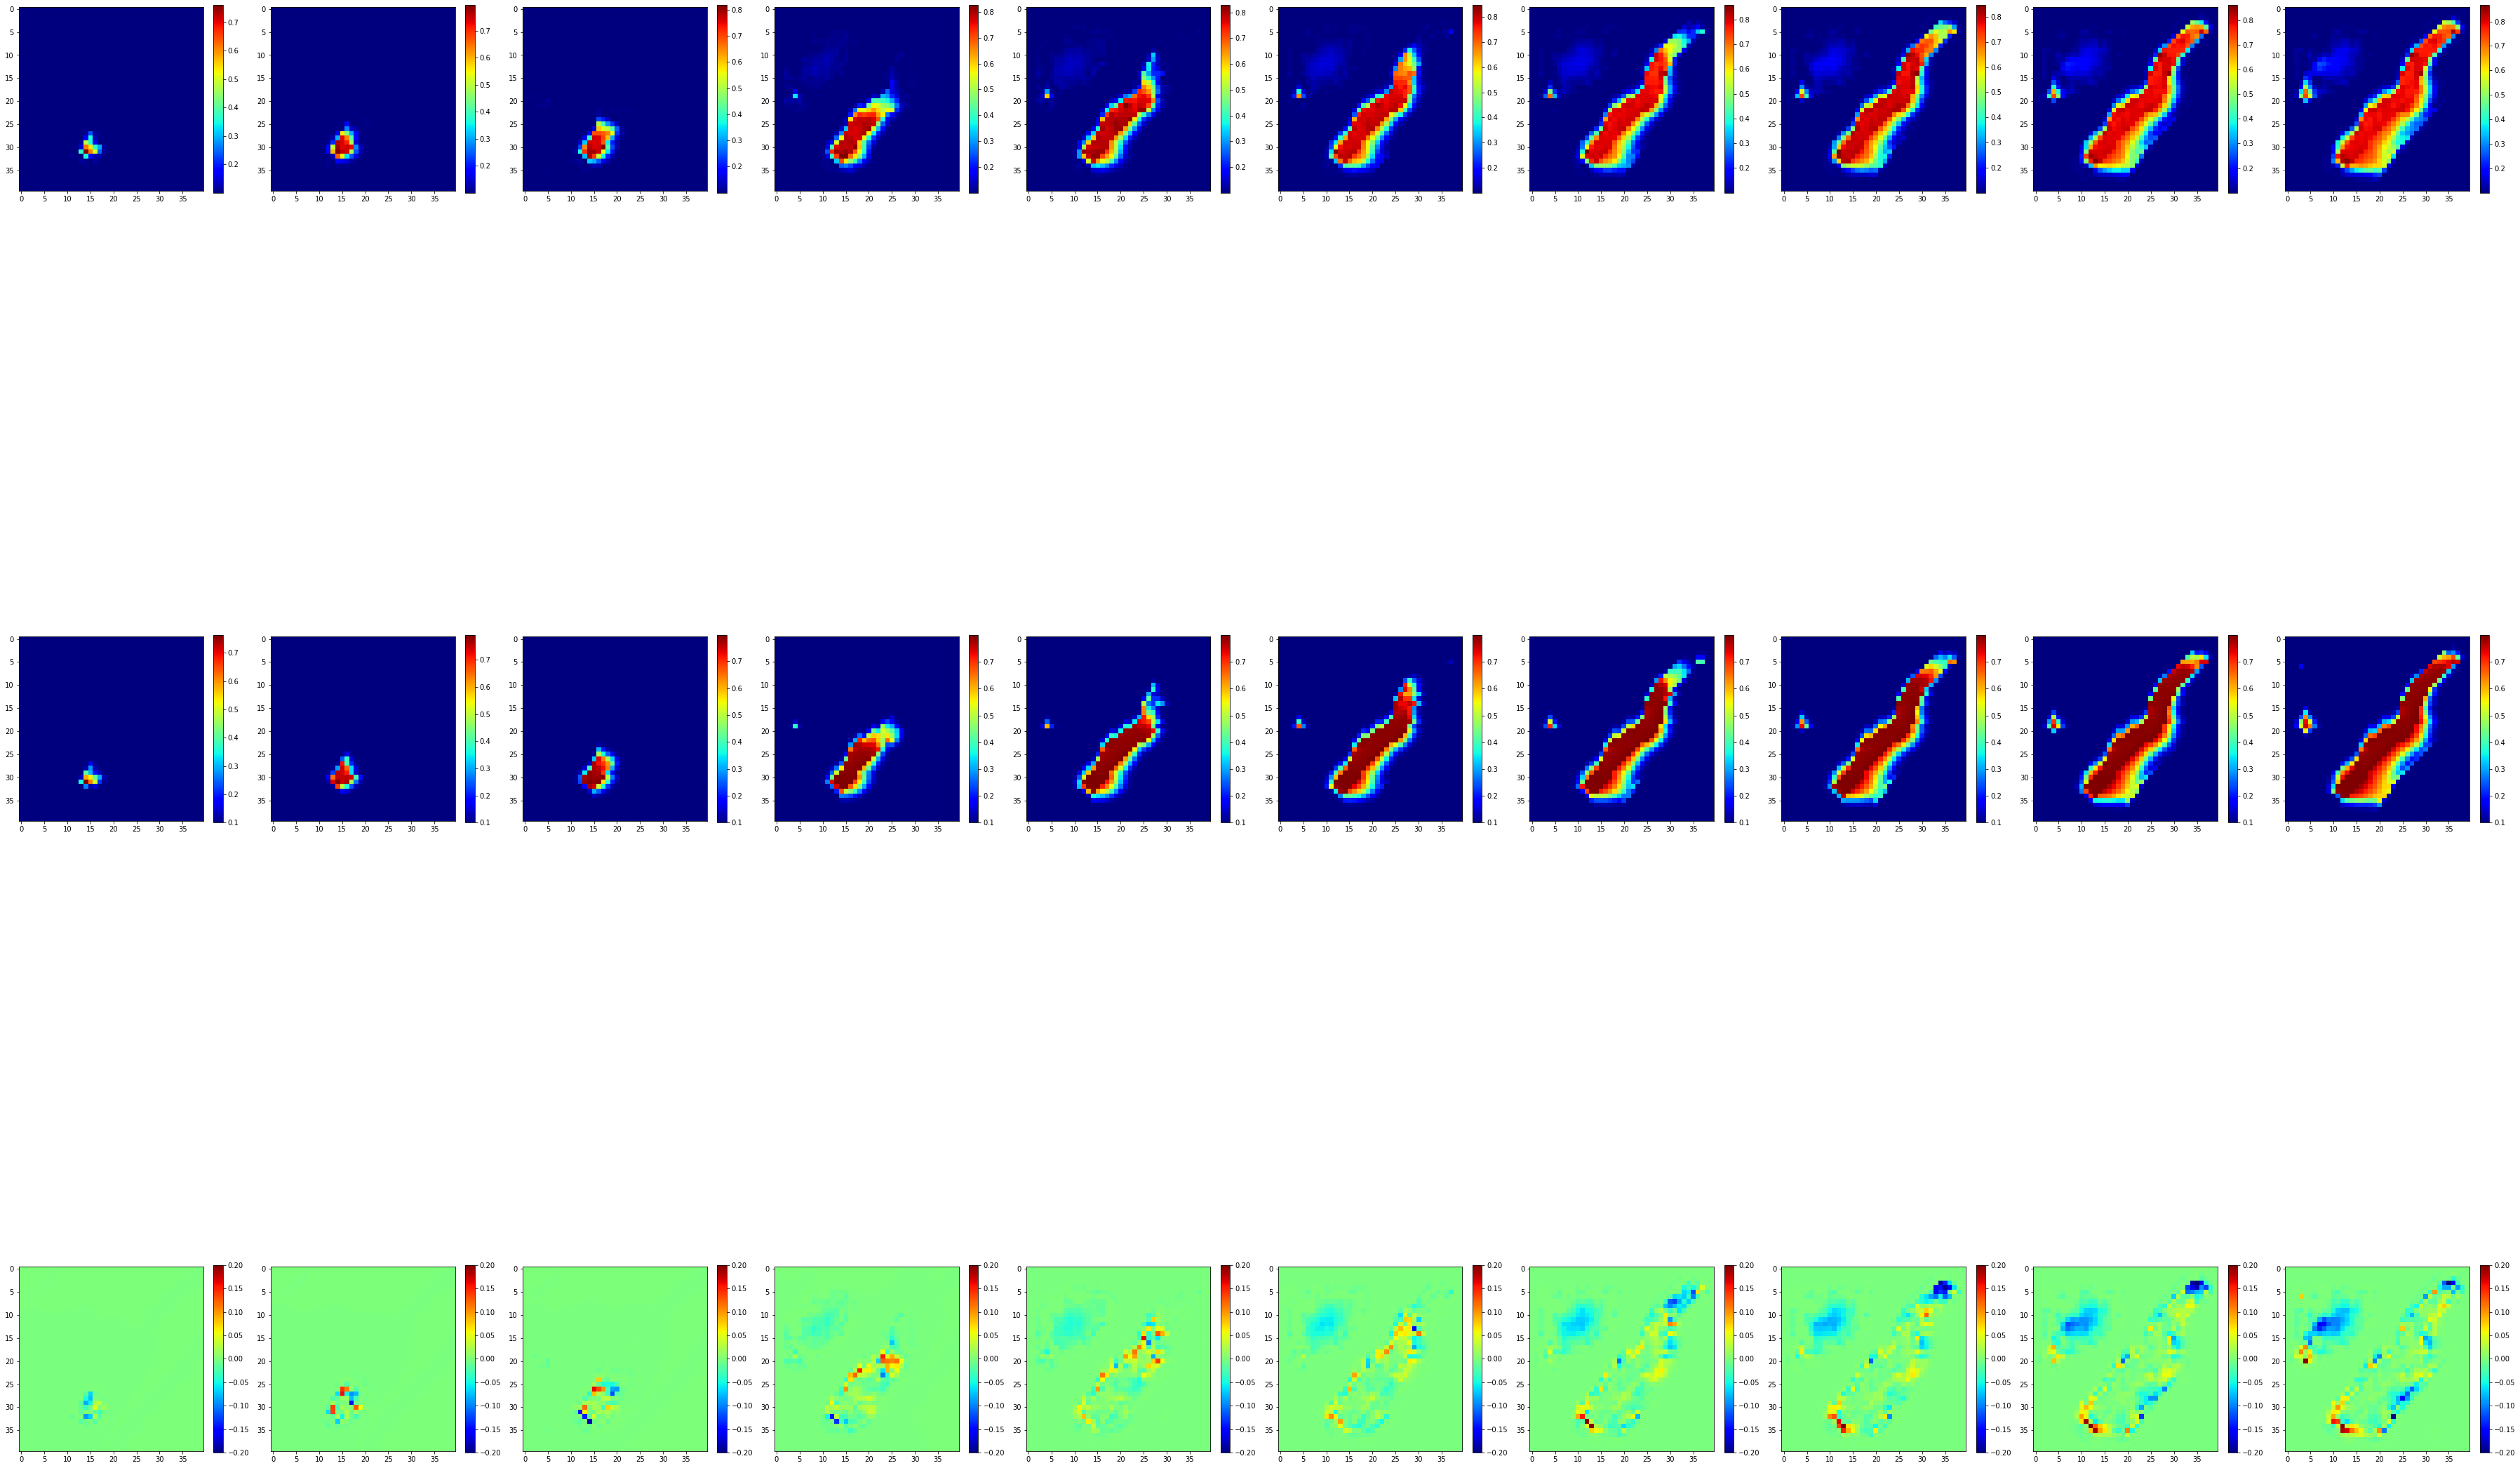

In [17]:
ind_z = 1
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep] - sat_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

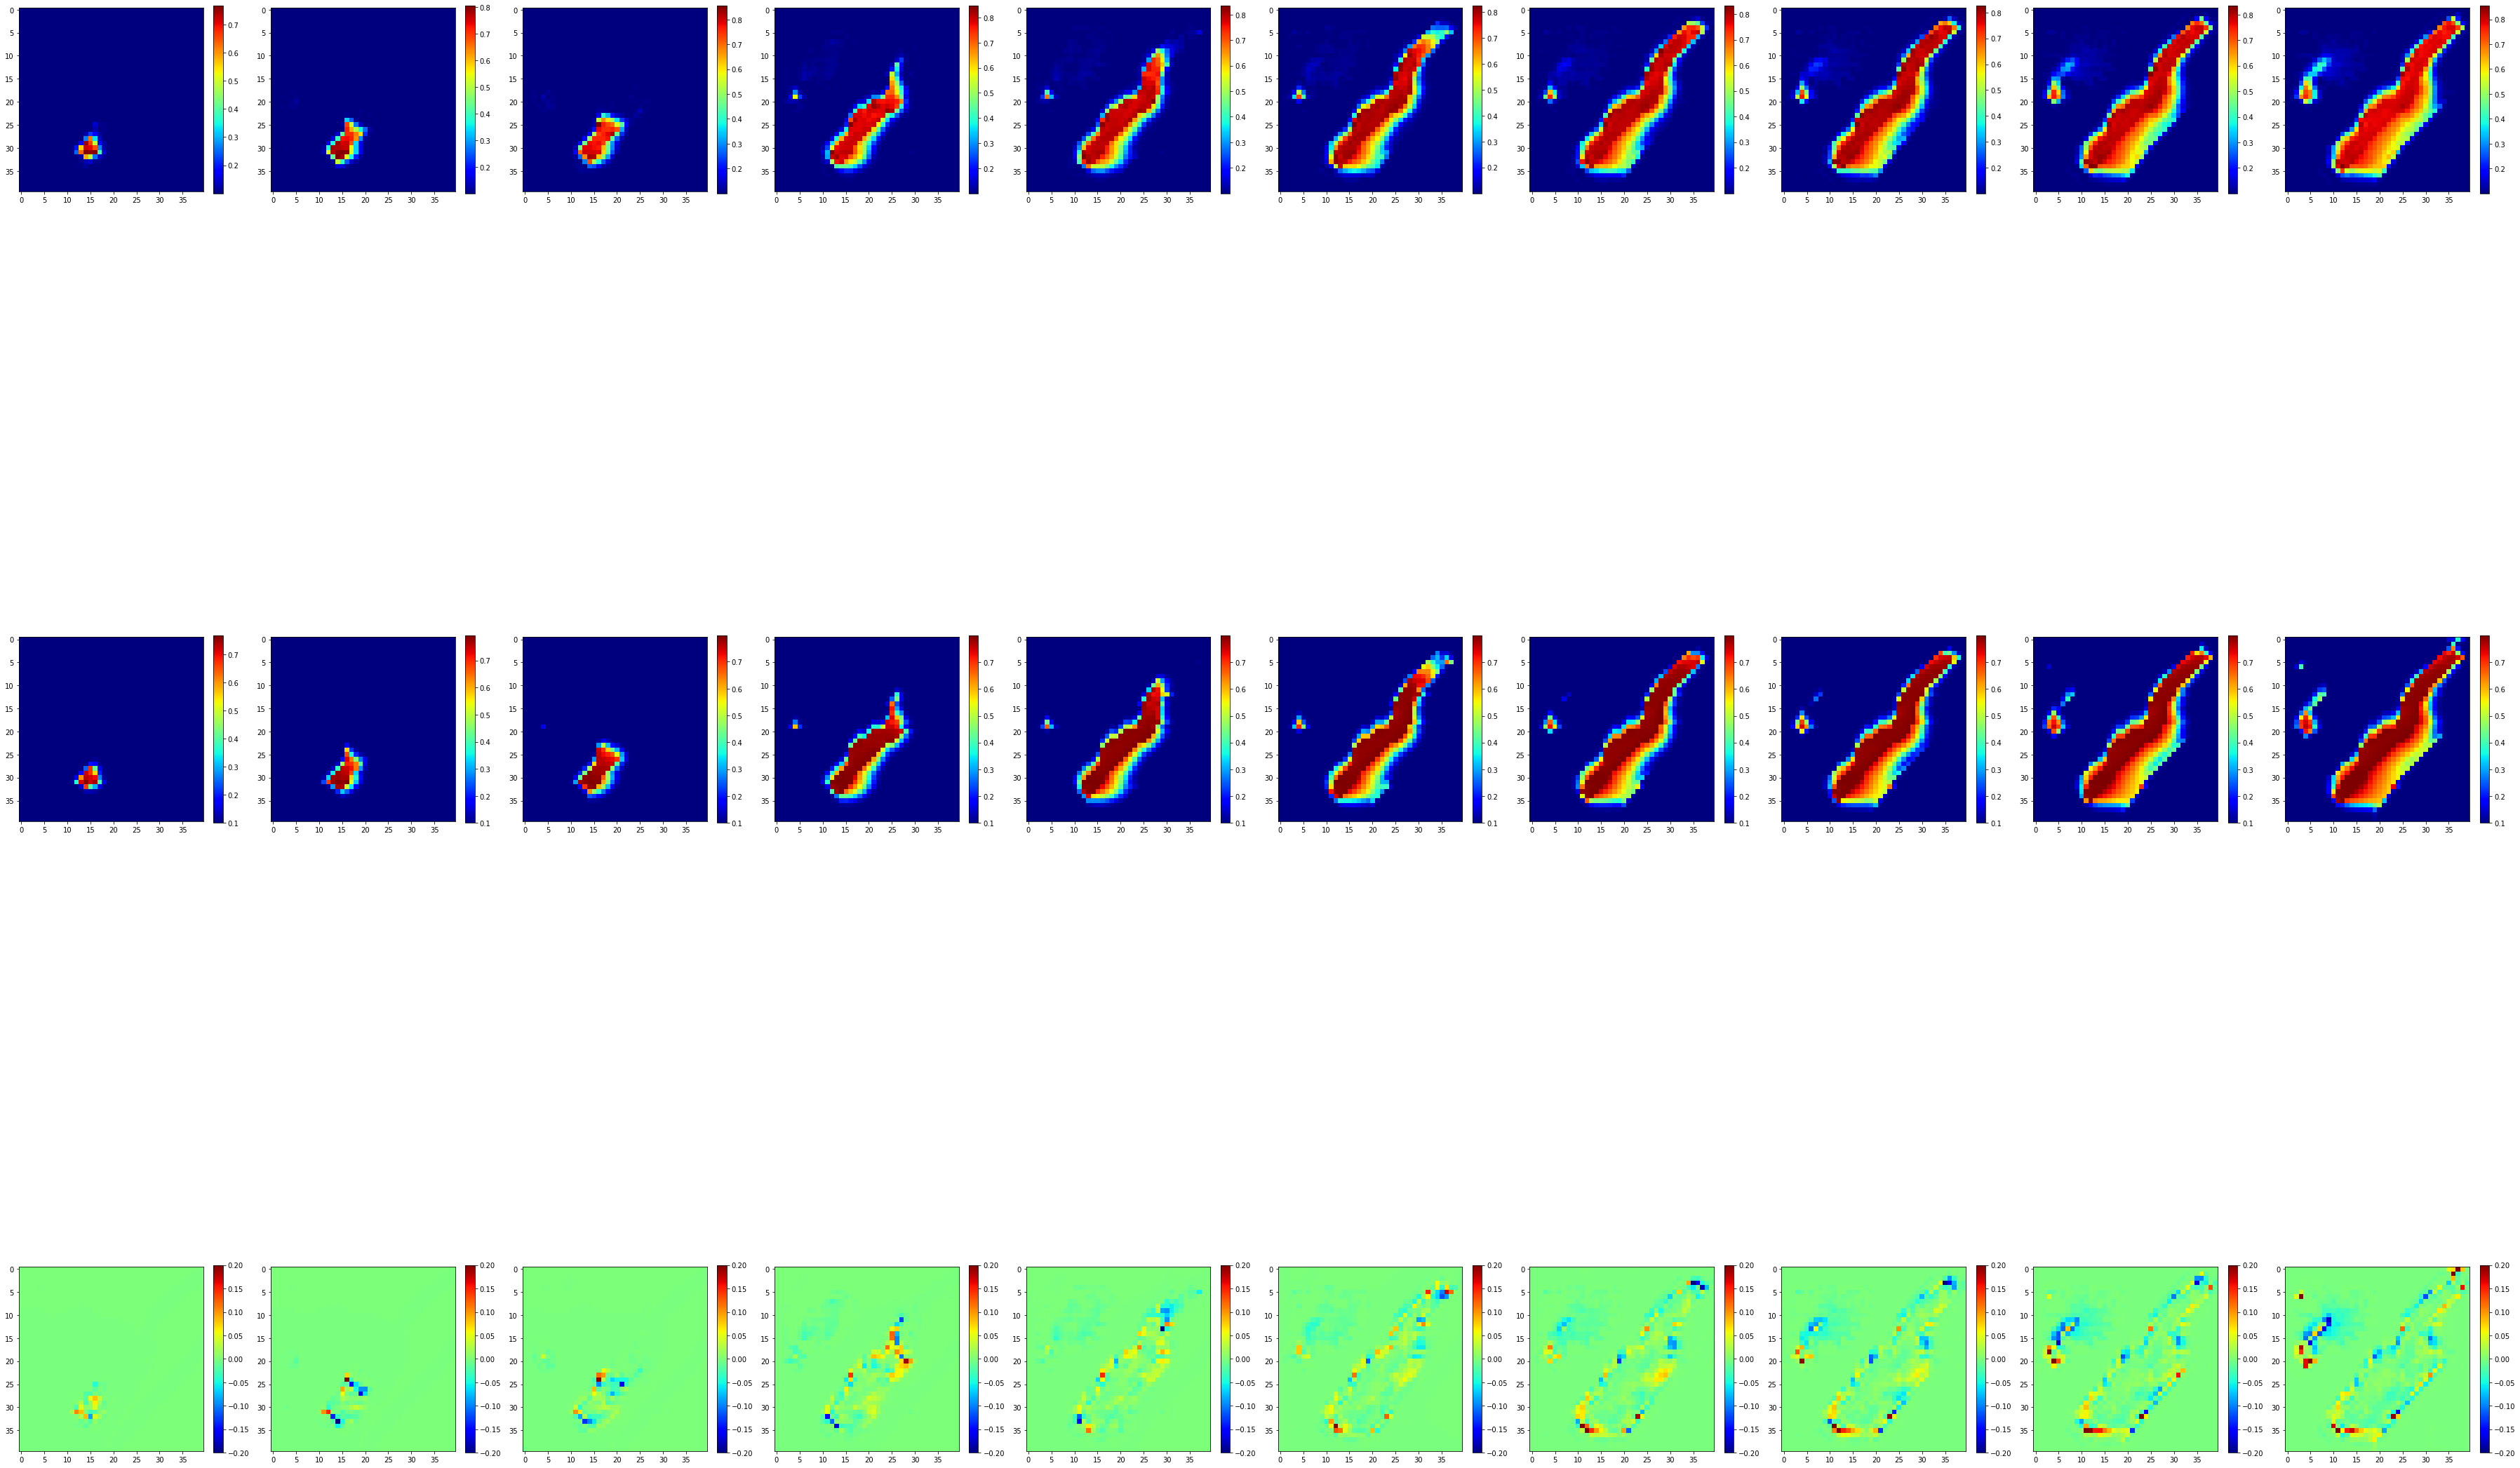

In [18]:
ind_z = 2
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep] - sat_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

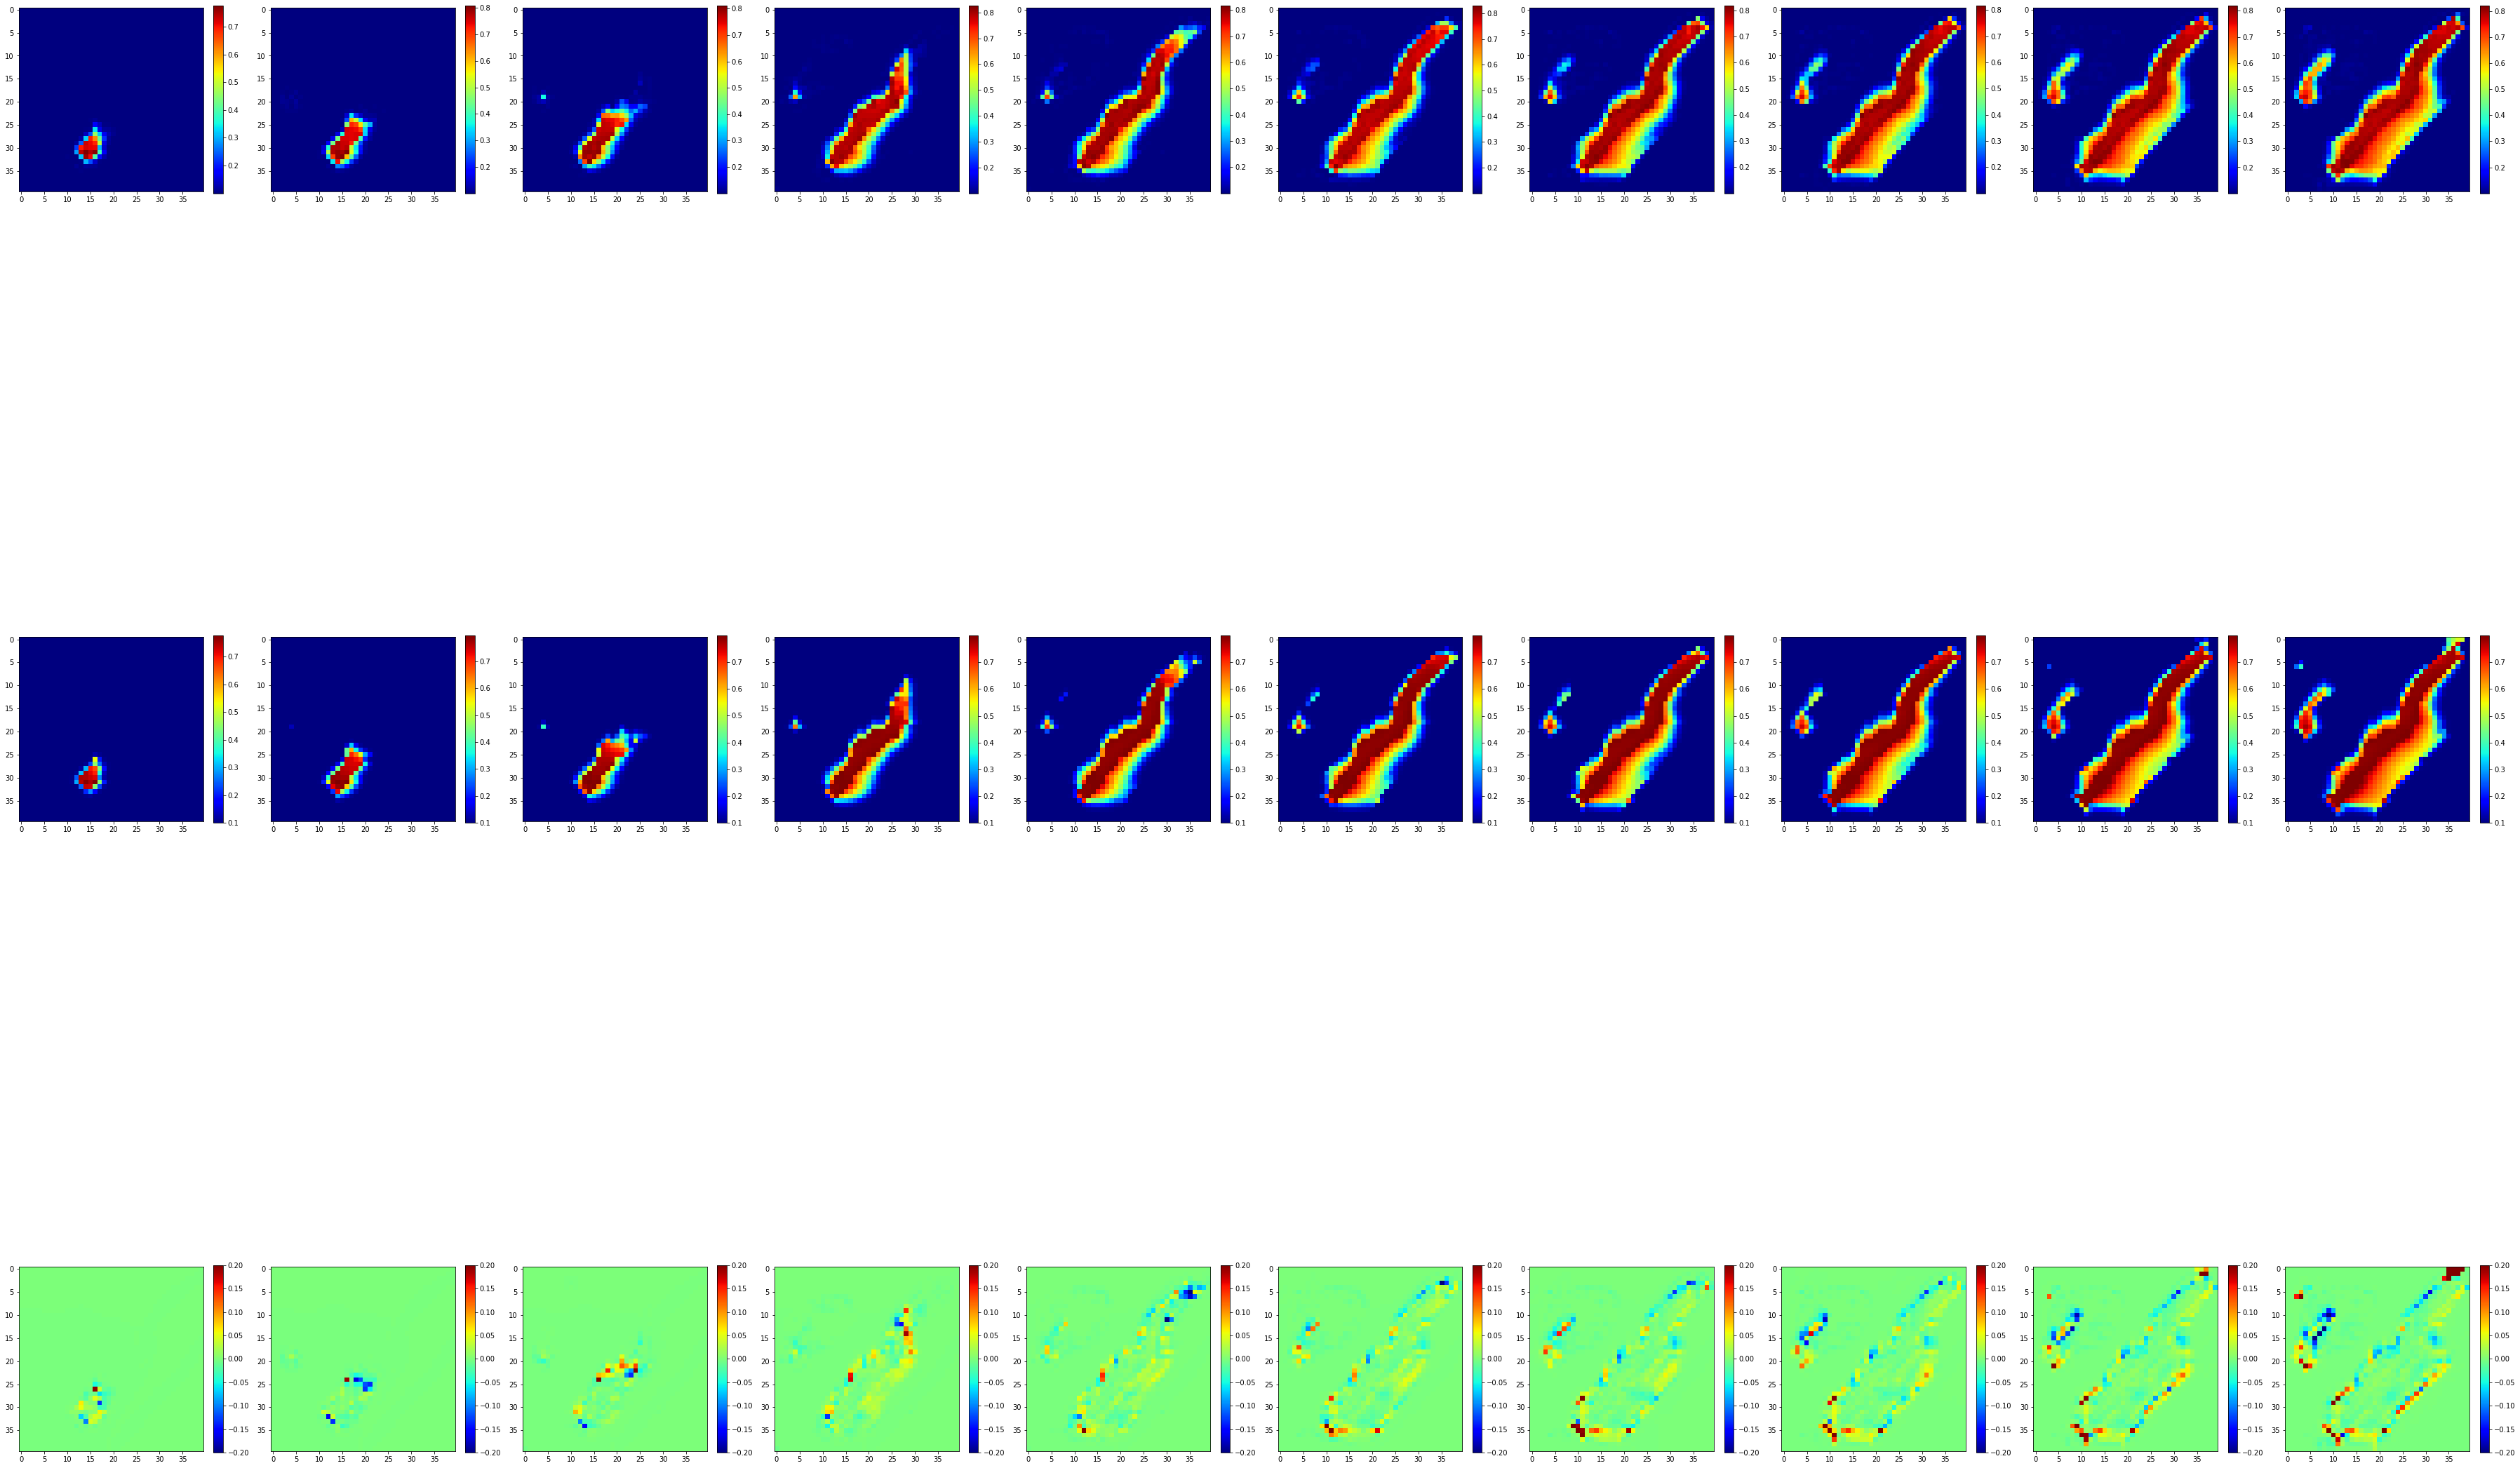

In [19]:
ind_z = 3
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep] - sat_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

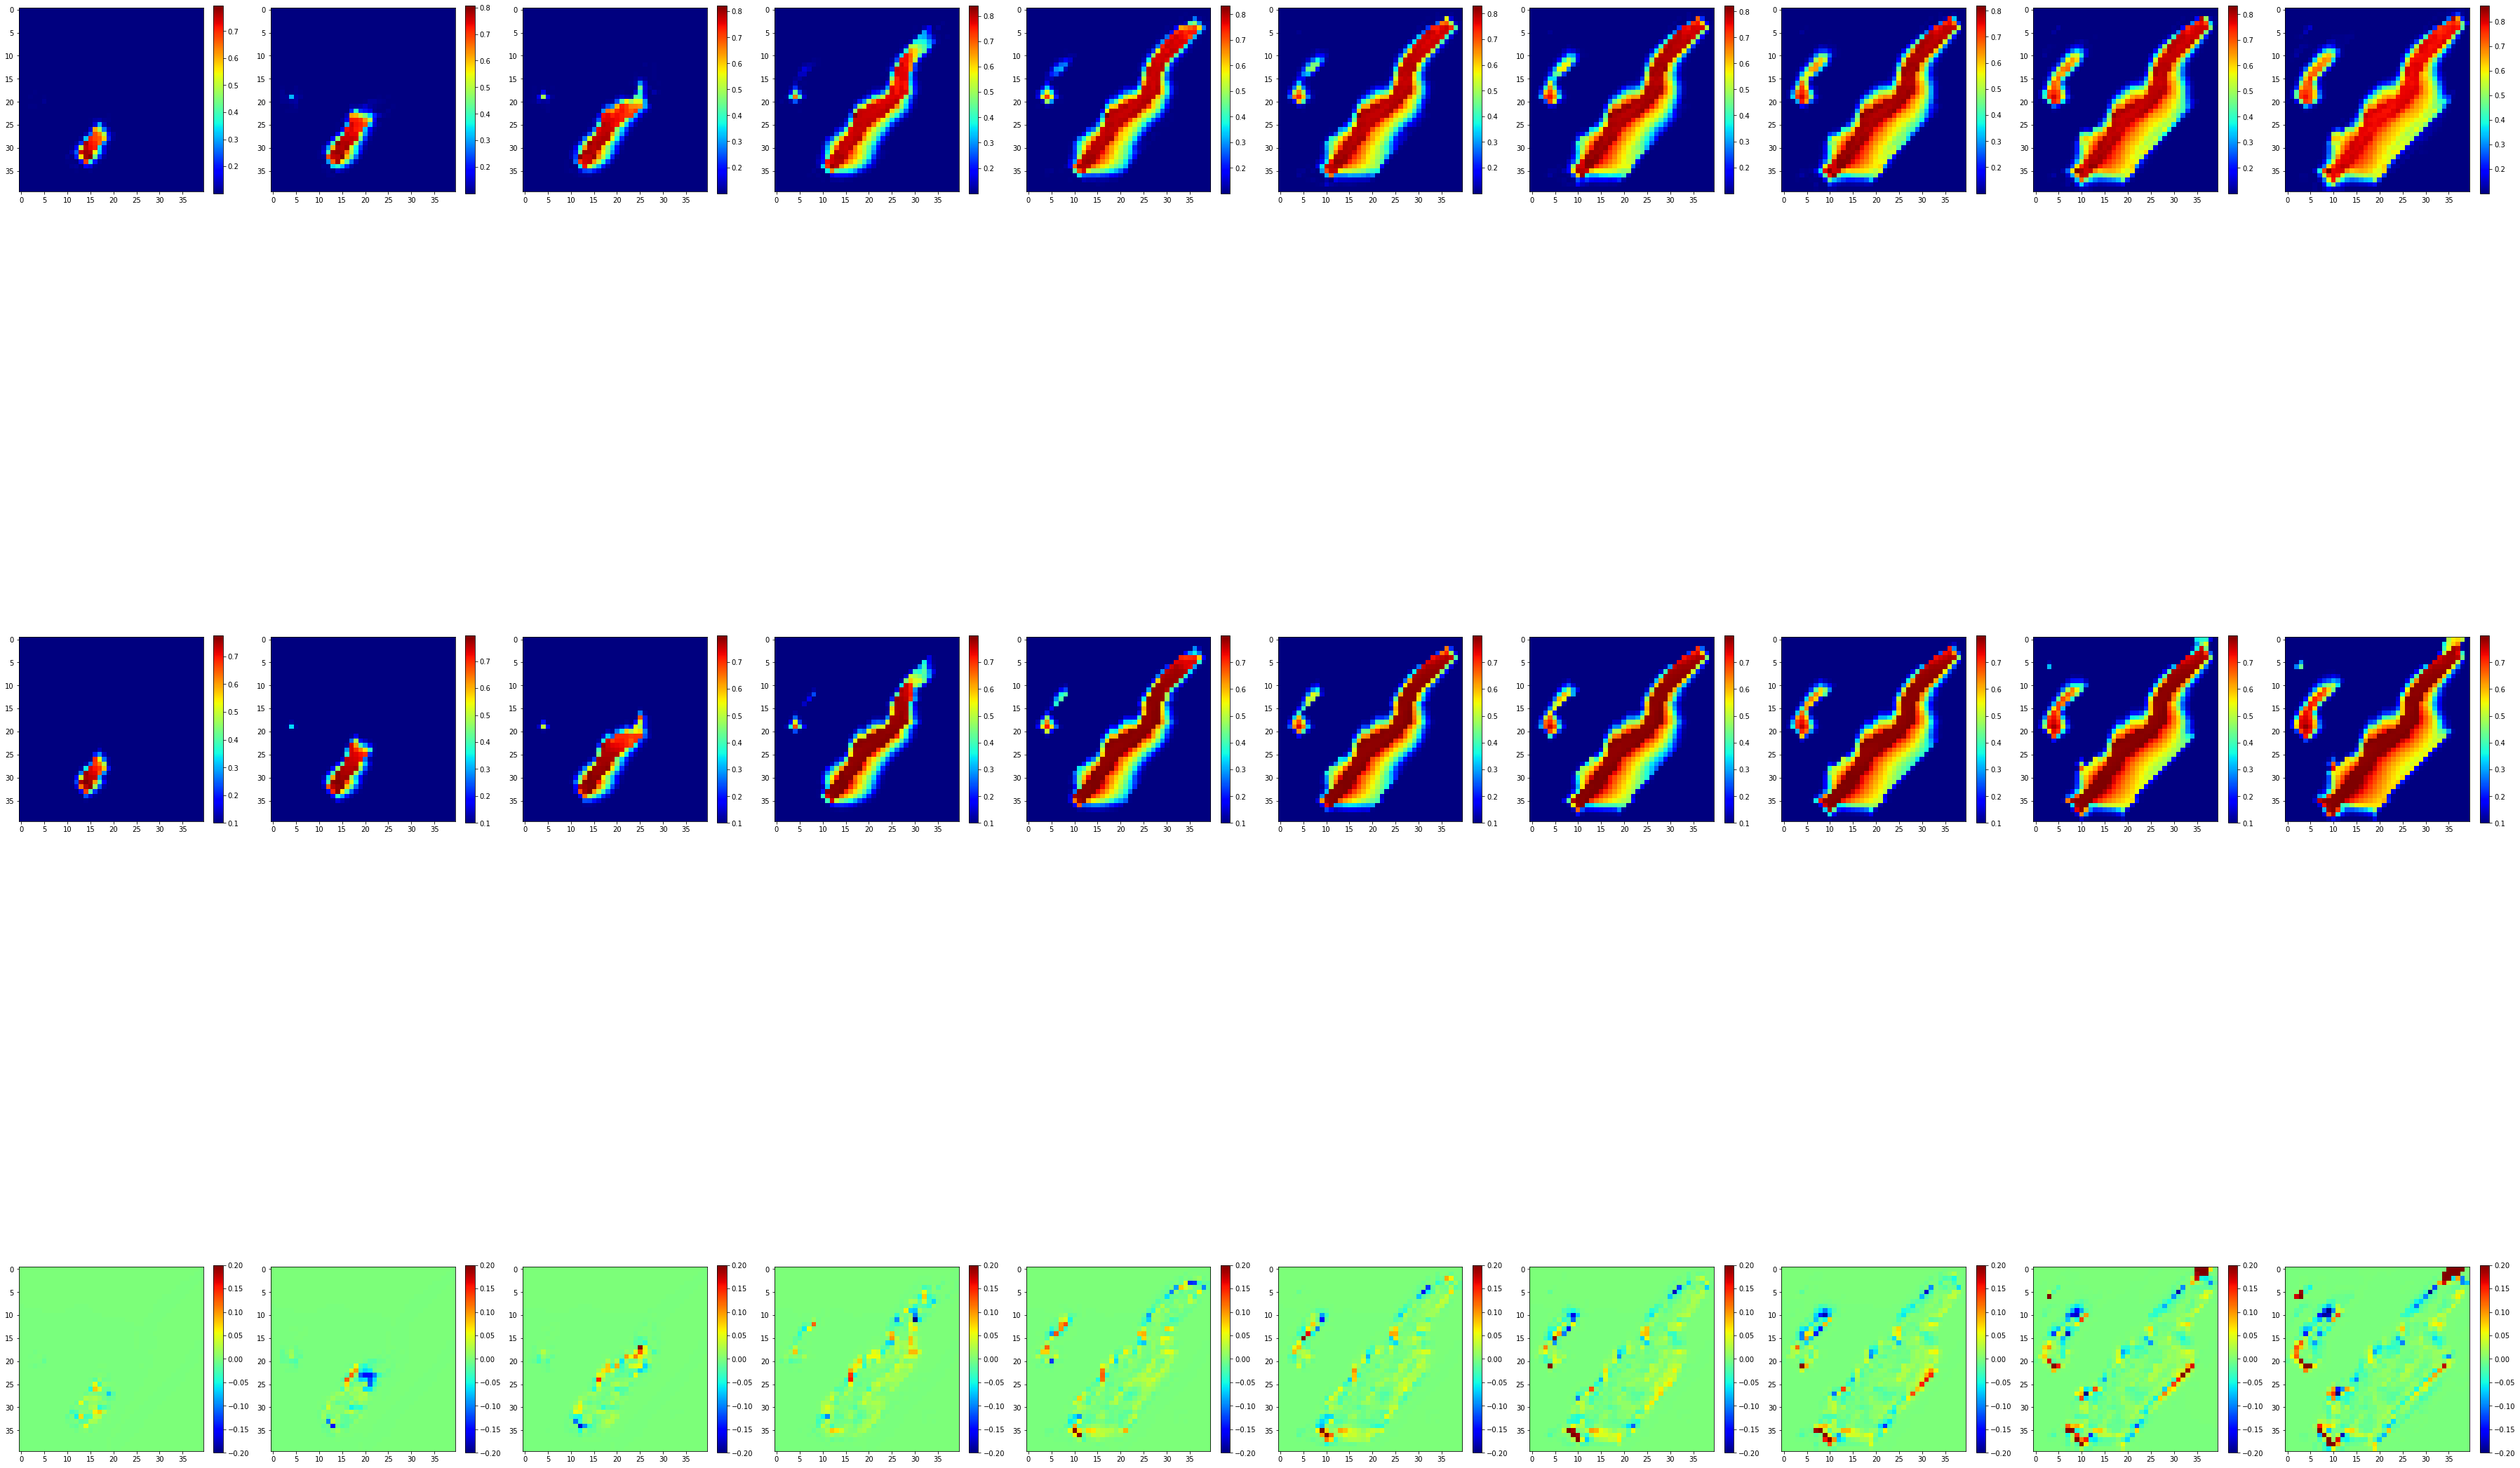

In [20]:
ind_z = 4
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, ind_z, :, :, i_tstep] - sat_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

## compute relative error

In [21]:
sat_pred.shape

(423, 20, 40, 40, 10)

In [22]:
error_in_time = np.mean(np.abs(sat_pred - sat_true) / sat_true, axis = (0, 1, 2, 3))

In [23]:
error_in_time

array([0.01168652, 0.02128656, 0.02929013, 0.0500841 , 0.0598363 ,
       0.06761806, 0.0740956 , 0.07971708, 0.08692594, 0.09411228])

In [26]:
hr = h5py.File('sat_pred_10steps_bs4_hd500_lr3e-4_filter_16_32_32_64.h5', 'w')
hr.create_dataset('sat_pred', data = sat_pred)
hr.create_dataset('sat_true', data = sat_true)
hr.close()